# 1. 의사결정나무 알고리즘 이해

PPT 참고

In [ ]:
# 로지스틱 회귀는 항상 모양이 s자 - 모수적
# 의사결정나무는 비모수적 따라서 분포에 맞게 모양을 구축가능
#soft voting은 클래스의 확률의 평균, hard voting은 클래스 개수가 많은걸 선택 

# 2. 머신러닝 모델 훈련과 예측

> 2.1 데이터 불러오기 \
2.2 데이터 분리 (X, y) \
2.3 모델 정의 \
2.4 모델 훈련 \
2.5 모델 예측

In [1]:
import os
import pandas as pd 
import numpy as np
import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2 # 자체적으로 만든 data loader version 2.0 ([데이콘 15회 대회] 데이터 설명 및 데이터 불러오기 영상 참조)
from tqdm import tqdm

In [2]:
train_folder = '../train/'
test_folder = '../test/'
train_label_path = '../etc/train_label.csv'

train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

In [3]:
# 모든 csv 파일의 상태_B로 변화는 시점이 같다라고 가정
# 하지만, 개별 csv파일의 상태_B로 변화는 시점은 상이할 수 있음
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(tqdm(pool.imap(func_fixed, files), total = len(files)))
        pool.close()
        pool.join()       
    combined_df = pd.concat(df_list)    
    return combined_df

## 2.1 데이터 불러오기

In [4]:
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=40) #30초간간의 데이터 샘플만 가져온다

100%|██████████| 826/826 [02:18<00:00,  5.97it/s]


In [5]:
test = data_loader_all_v2(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=10, nrows=40)

100%|██████████| 718/718 [02:00<00:00,  5.97it/s]


In [6]:
import time

In [9]:
#start = time.time()
#train = pd.read_csv('../train', index_col = 0)
#test = pd.read_csv('../test', index_col = 0)
#print(time.time() - start)

## 2.2 데이터 분리 (X, y)

In [10]:
train.head()

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120,label
0,30.474394,8.691177,8.714483,8.687399,8.721230,207.697895,165.865730,-6.018877e-19,0.0,-0.002136,...,1.0,1.0,1.0,60.0,0.0,0.0,1.421620e-05,85.4,0.0,110
0,30.470463,8.736521,8.682769,8.717135,8.682402,192.665080,191.006871,-3.918758e-19,0.0,0.001710,...,1.0,1.0,1.0,60.0,0.0,0.0,-6.114455e-06,85.4,0.0,110
0,30.465427,8.753559,8.663426,8.700049,8.734147,187.065171,192.700238,-1.799179e-19,0.0,0.000493,...,1.0,1.0,1.0,60.0,0.0,0.0,-1.813291e-05,85.4,0.0,110
0,30.458532,8.715056,8.714854,8.717174,8.699257,188.500036,180.150567,-6.636971e-19,0.0,0.000318,...,1.0,1.0,1.0,60.0,0.0,0.0,-5.745568e-07,85.4,0.0,110
0,30.475773,8.790241,8.735125,8.703167,8.721030,193.269046,195.984890,-6.379752e-20,0.0,-0.000091,...,1.0,1.0,1.0,60.0,0.0,0.0,8.437883e-06,85.4,0.0,110


In [11]:
X_train = train.drop(['label'], axis=1) #axis =1 : column 
y_train = train['label']

## 2.3 모델 정의

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1) #random성을 고정, random_state = 아무숫자, #n_jobs = -1 =>모든 cpu를 활용하겠다!

## 2.4 모델 훈련

In [14]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=1)

## 2.5 모델 예측

In [15]:
pred = model.predict_proba(test) # proba는 probability 따라서 soft votiong #그냥 예측만 하면 hard로
submission = pd.DataFrame(data=pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished


In [16]:
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()

In [18]:
submission.to_csv('feat5120.csv') # 저장

# III. 데이터 전처리와 탐색적 분석

### pd.DataFrame.isnull()
- 결측치 여부를 확인해줍니다.
- 결측치면 True, 아니면 False

In [37]:
train.isnull()

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
train.isnull().sum()

V0000    0
V0001    0
V0002    0
V0003    0
V0004    0
        ..
V5117    0
V5118    0
V5119    0
V5120    0
label    0
Length: 5122, dtype: int64

In [39]:
train.isnull().sum().sum()

0

In [2]:
!pip install missingno

In [3]:
import missingno as msno 

### msno.bar()
- 칼럼별 값이 채워진 비율을 시각화 

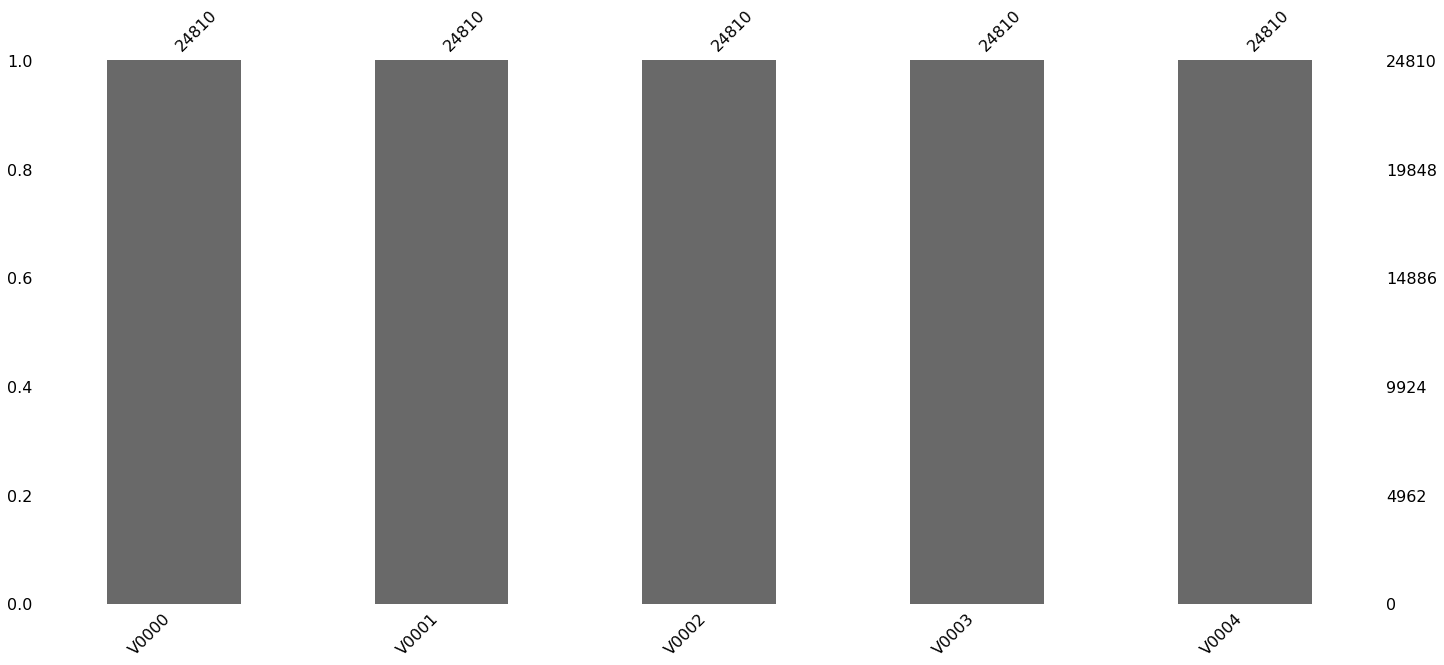

In [42]:
msno.bar(train.loc[:, :'V0004']) #5개 칼럼만 가져옴 # 해당칼럼에 얼마나 채워져 있냐 퍼센트로

### msno.matrix()
- 칼럼별 값이 채워진 위치를 시각화

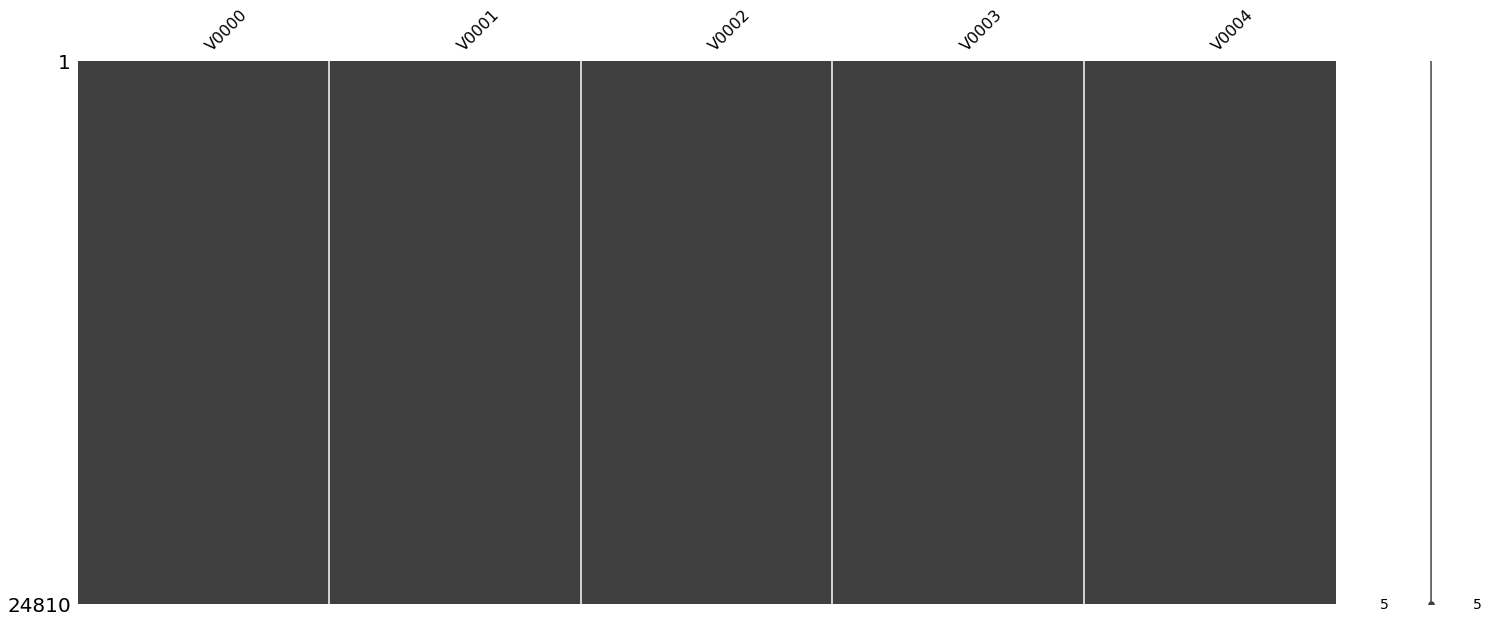

In [43]:
msno.matrix(train.loc[:, :'V0004'])

In [8]:
_save = train.iloc[:10000, 1].values.copy() # copy()를 꼭 해 줘야 hard copy가 됨.
train.iloc[:10000, 1] = np.nan

In [61]:
train.iloc[:10000, 1] = _save
train

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120,label
0,NaN,8.691177,8.714483,8.687399,8.721230,207.697895,165.865730,-6.018877e-19,0.0,-0.002136,...,1.0,1.0,1.0,60.0,0.0,0.0,1.421620e-05,85.4,0.0,110
0,NaN,8.736521,8.682769,8.717135,8.682402,192.665080,191.006871,-3.918758e-19,0.0,0.001710,...,1.0,1.0,1.0,60.0,0.0,0.0,-6.114455e-06,85.4,0.0,110
0,NaN,8.753559,8.663426,8.700049,8.734147,187.065171,192.700238,-1.799179e-19,0.0,0.000493,...,1.0,1.0,1.0,60.0,0.0,0.0,-1.813291e-05,85.4,0.0,110
0,NaN,8.715056,8.714854,8.717174,8.699257,188.500036,180.150567,-6.636971e-19,0.0,0.000318,...,1.0,1.0,1.0,60.0,0.0,0.0,-5.745568e-07,85.4,0.0,110
0,NaN,8.790241,8.735125,8.703167,8.721030,193.269046,195.984890,-6.379752e-20,0.0,-0.000091,...,1.0,1.0,1.0,60.0,0.0,0.0,8.437883e-06,85.4,0.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,30.467389,8.667824,8.688698,8.675708,8.677447,247.317747,235.228012,-2.822292e-19,0.0,0.000271,...,1.0,1.0,1.0,60.0,0.0,0.0,-5.678521e-06,85.4,0.0,156
99,30.460052,8.701218,8.705593,8.677823,8.700603,225.258851,236.321720,5.962155e-19,0.0,-0.000625,...,1.0,1.0,1.0,60.0,0.0,0.0,9.612709e-06,85.4,0.0,156
99,30.452393,8.798497,8.702983,8.714415,8.674383,248.134756,219.790195,4.982188e-19,0.0,0.000123,...,1.0,1.0,1.0,60.0,0.0,0.0,-1.285006e-05,85.4,0.0,156
99,30.459519,8.741143,8.718227,8.651756,8.712503,218.261447,189.666757,7.138593e-20,0.0,0.001317,...,1.0,1.0,1.0,60.0,0.0,0.0,2.867083e-05,85.4,0.0,156


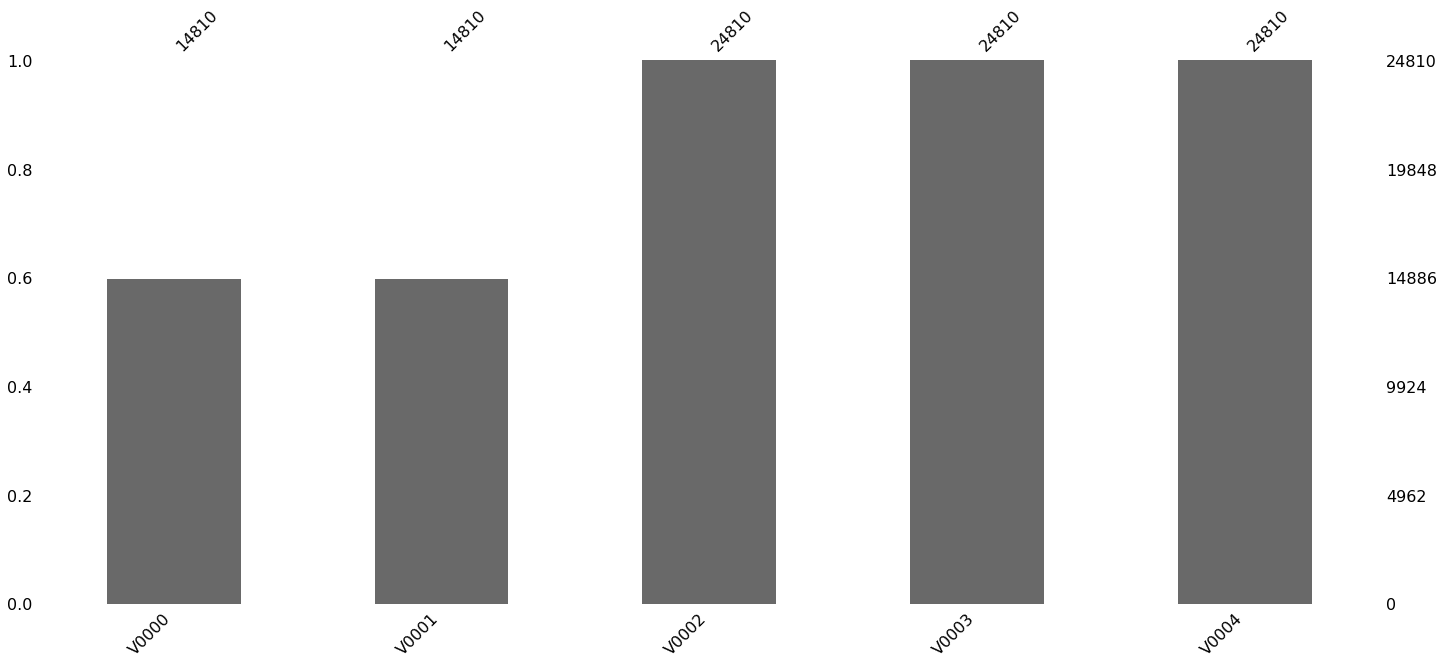

In [63]:
msno.bar(train.loc[:, :'V0004'])

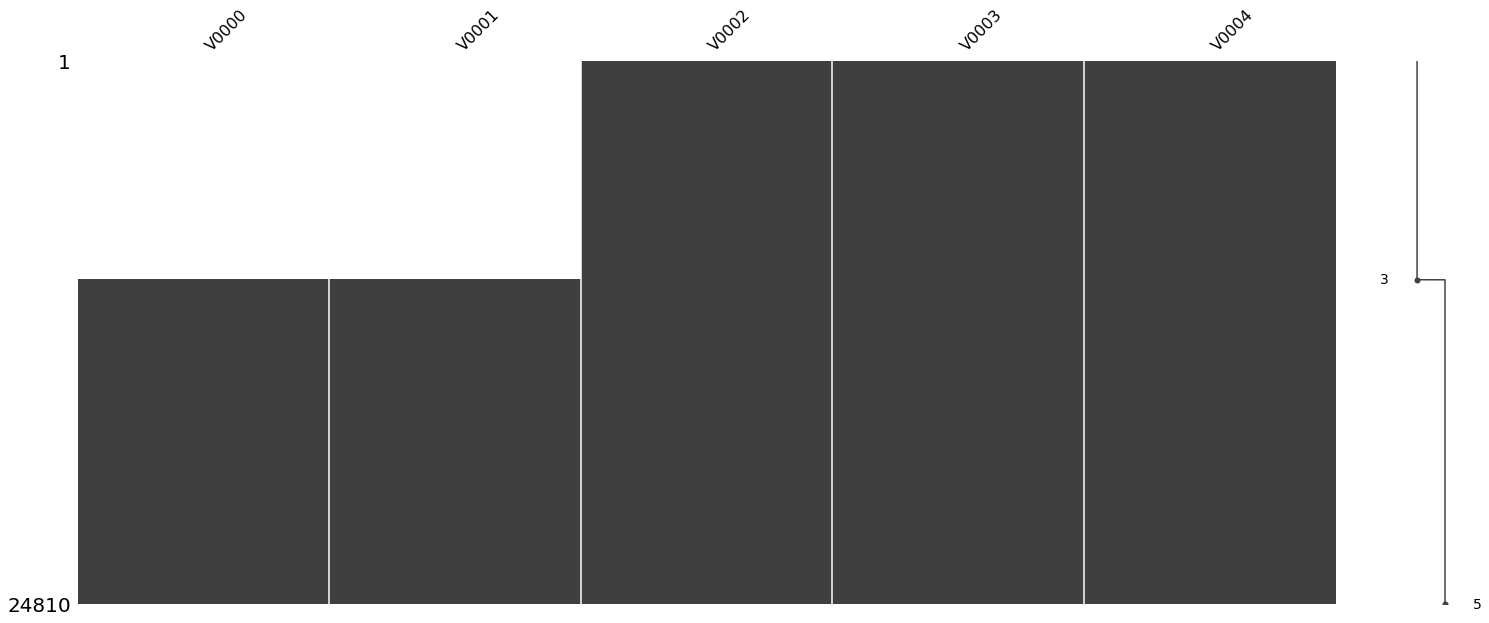

In [64]:
msno.matrix(train.loc[:, :'V0004'])

### pd.Series.fillna()
- 결측치를 채우고자 하는 column과 결측치를 대신하여 넣고자 하는 값을 명시해주어야 합니다.
- 범주형 변수일 경우, 최빈값으로 대체할 수 있습니다. 

In [ ]:
train['V0001'].fillna(value=train['VOOO1'].mean()) #VOOO1의 평균값으로 채우기

0        30.360653
1        30.360653
2        30.360653
3        30.360653
4        30.360653
           ...    
24805    30.467389
24806    30.460052
24807    30.452393
24808    30.459519
24809    30.473445
Name: V0000, Length: 24810, dtype: float64

### pd.DataFrame.nunique()
- 컬럼별 unique한 값의 개수 반환

In [13]:
num_unique = train.nunique()

In [14]:
num_unique != 1 #고유값이 1개면 분류에 도움이 안됨 # 의사결정트리에서 노드에서 질문할 때마다 값이 1개면 모든 데이터들이 한 쪽에 몰려서 순도율이 바뀌지않음.

Unnamed: 0     True
V0000          True
V0001          True
V0002          True
V0003          True
              ...  
V5117         False
V5118          True
V5119          True
V5120         False
label          True
Length: 5123, dtype: bool

In [66]:
train.loc[:, num_unique !=1]

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119,label
0,NaN,NaN,8.714483,8.687399,8.721230,207.697895,165.865730,-6.018877e-19,0.0,-0.002136,...,110.981328,-0.292202,-0.227825,-0.199740,-0.155360,43.204967,60.0,1.421620e-05,85.4,110
0,NaN,NaN,8.682769,8.717135,8.682402,192.665080,191.006871,-3.918758e-19,0.0,0.001710,...,110.994106,-0.286190,-0.240191,-0.183798,-0.149832,43.189223,60.0,-6.114455e-06,85.4,110
0,NaN,NaN,8.663426,8.700049,8.734147,187.065171,192.700238,-1.799179e-19,0.0,0.000493,...,110.846185,-0.283542,-0.254116,-0.173975,-0.160714,43.193726,60.0,-1.813291e-05,85.4,110
0,NaN,NaN,8.714854,8.717174,8.699257,188.500036,180.150567,-6.636971e-19,0.0,0.000318,...,111.074215,-0.302789,-0.228363,-0.135186,-0.147648,43.207052,60.0,-5.745568e-07,85.4,110
0,NaN,NaN,8.735125,8.703167,8.721030,193.269046,195.984890,-6.379752e-20,0.0,-0.000091,...,110.839118,-0.296479,-0.249304,-0.193827,-0.141245,43.200405,60.0,8.437883e-06,85.4,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,30.467389,8.667824,8.688698,8.675708,8.677447,247.317747,235.228012,-2.822292e-19,0.0,0.000271,...,110.855242,-0.291317,-0.239526,-0.160873,-0.147279,43.192200,60.0,-5.678521e-06,85.4,156
99,30.460052,8.701218,8.705593,8.677823,8.700603,225.258851,236.321720,5.962155e-19,0.0,-0.000625,...,110.760693,-0.302359,-0.228090,-0.208819,-0.175458,43.206268,60.0,9.612709e-06,85.4,156
99,30.452393,8.798497,8.702983,8.714415,8.674383,248.134756,219.790195,4.982188e-19,0.0,0.000123,...,110.843740,-0.302417,-0.237594,-0.186483,-0.143880,43.198456,60.0,-1.285006e-05,85.4,156
99,30.459519,8.741143,8.718227,8.651756,8.712503,218.261447,189.666757,7.138593e-20,0.0,0.001317,...,110.918720,-0.295908,-0.229464,-0.177796,-0.148053,43.206099,60.0,2.867083e-05,85.4,156


In [67]:
test.loc[:, num_unique != 1]

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5084,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119
id,,,,,,,,,,,,,,,,,,,,,
1000,30.465741,8.618514,8.705075,8.730912,8.699214,181.327530,201.889419,2.393806e-19,0.0,0.003496,...,110.940222,110.849652,-0.294763,-0.229694,-0.172642,-0.181698,43.203640,60.0,0.000004,85.4
1000,30.477302,8.642689,8.713423,8.732450,8.694666,203.347675,155.790045,-1.808861e-19,0.0,0.001969,...,110.767512,110.853183,-0.286671,-0.232155,-0.177659,-0.164828,43.195677,60.0,0.000005,85.4
1000,30.478336,8.675928,8.729837,8.672877,8.710215,196.673652,227.039249,6.236627e-19,0.0,-0.002462,...,110.831842,110.935070,-0.299707,-0.249112,-0.193733,-0.170861,43.192395,60.0,0.000016,85.4
1000,30.462904,8.733765,8.706455,8.691974,8.696285,194.365551,167.436935,2.845012e-20,0.0,-0.000045,...,110.936369,110.873987,-0.284462,-0.240052,-0.166091,-0.164244,43.195476,60.0,-0.000010,85.4
1000,30.483675,8.807382,8.680733,8.713651,8.664766,205.369347,154.245975,-2.085638e-19,0.0,-0.000713,...,110.987712,110.927734,-0.283827,-0.230030,-0.228277,-0.139462,43.193896,60.0,-0.000008,85.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,30.496147,8.741427,8.653808,8.691350,8.726794,194.343888,202.876145,1.498980e-19,0.0,0.000421,...,110.880615,110.878885,-0.294877,-0.244443,-0.178633,-0.170736,43.204551,60.0,-0.000003,85.4
999,30.465789,8.738011,8.692180,8.687480,8.713029,227.858869,194.443682,-2.037335e-19,0.0,0.000515,...,110.882186,110.933750,-0.279949,-0.235735,-0.212362,-0.158467,43.195530,60.0,-0.000002,85.4
999,30.497398,8.789116,8.699522,8.644117,8.688202,173.354241,196.747357,3.434190e-19,0.0,0.002840,...,110.851891,110.861816,-0.302651,-0.253262,-0.192765,-0.141668,43.194715,60.0,-0.000005,85.4


### Ablation Study(두 실험의 차이를 봄으로써 특정 변수의 영향력을 파악하는 실험)를 위한 함수 정의

1. 약 5000개의 변수를 사용했을 때보다, 3000개의 변수만 사용하면 성능이 좋아질까?
2. 주어진 모델 조건은 동일, 사용하는 훈련데이터셋만 변경

In [28]:
# 실험할 때마다 코드를 짜면 비효율적이므로 함수를 정의해서 사용
def validate_model(df):#df가 입력값
    
    model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
    
    X_train = df.drop('label', axis = 1)
    y_train = df['label']
    
    
    model.fit(X_train, y_train)
    
    
    return model 

In [23]:
model_1 = validate_model(train.loc[:, train.nunique() != 1])
# 칼럼별 unique한 값이 1인 것을 제외하고 train 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


In [24]:
def predict_model(model, df):
    
    pred = model.predict_proba(df)
    submission = pd.DataFrame(data=pred)
    submission.index = df.index
    submission.index.name = 'id'
    submission = submission.sort_index()
    submission = submission.groupby('id').mean()
    
    return submission

In [31]:
submit = predict_model(model_1, test.loc[:, train.nunique() != 1])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished
